# Mel Schwan, Stuart Miller, Justin Howard, Paul Adams
# Lab Two: Classification

## MiniLab2 Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Define and prepare your class variables](#Define)
    2. [Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created](#FinalDataset)


2. [Modeling and Evaluation](#DataUnderstanding)
    1. [Choose and explain your evaluation metrics that you will use](#Evaluaation)
    2. [Choose the method you will use for dividing your data into training and
testing splits](#DivideData)
    3. [Create three different classification/regression models](#Models)
    4. [Analyze the results using your chosen method of evaluation](#Analyze)
    5. [Discuss the advantages of each model for each classification task](#Advantages)
    6. [Which attributes from your analysis are most important](#Attributes)
    
    
3. [Deployment](#Deployment)
    1. [How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the
model's value if it was used by these parties? How would your deploy your model for
interested parties? What other data should be collected? How often would the model
need to be updated, etc.?](#Value)

A1. [Disclaimer](#Disclaimer)

<img src="./crisps-dm2.png" style="width:550px;height:450px"/>


# Dataset Selection

# 1. Stage Three - Data Preperation (Q1)   <a class="anchor" id="DataPreparation"></a>

## 1.1 Define and prepare your class variables (Q1A)<a class="anchor" id="Define"></a>

In [1]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#plotting library
import altair as alt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# others
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions
from sklearn.metrics import roc_curve, auc

from sklearn.base import BaseEstimator, TransformerMixin


from statsmodels.stats.outliers_influence import variance_inflation_factor

# custom functions
from cleaning import (read_clean_data, impute_data, merge_bureau, merge_previous_application,
merge_POS_CASH, merge_credit_card_balance, merge_installments, downsampling_strategy, reduce_mem_usage)
from tables import classification_report

# set random seed
random_state= 1
np.random.seed(random_state)

## 1.0 Loading and Merging the Dataset

In [2]:
# loading data that was preprocessed using the custom read_clean_data() function, 
# merged with the previously engineered newFeatures from Lab 1 
data = read_clean_data()

In [3]:
data_bureau = merge_bureau(data)
data_prev = merge_previous_application(data_bureau)
data_POS_CASH = merge_POS_CASH(data_prev)
data_installments = merge_installments(data_POS_CASH)
data_full = merge_credit_card_balance(data_installments)

The shape application and bureau data combined: (307511, 115)
Dimensions after adding new features:  (307511, 119)
Dimensions after adding previous_application:  (307511, 282)
Dimensions after adding POS_CASH_balance:  (307511, 296)
Dimensions after adding installments:  (307511, 302)
Dimensions after adding credit_card_balance:  (307511, 329)


In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 329 entries, SK_ID_CURR to CREDIT_NAME_CONTRACT_STATUS_Signed
dtypes: float32(2), float64(265), int32(15), int64(36), uint16(10), uint32(1)
memory usage: 735.5 MB


In [5]:
data_lite = reduce_mem_usage(data_full)

Memory usage of dataframe is 735.51 MB
Memory usage after optimization is: 202.06 MB
Decreased by 72.5%


In [4]:
data.CNT_FAM_MEMBERS.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., 14., 12.,
       20., 15., 16., 11.])

The dataset contains features, such as the number of children an applicant has, where the number of unique values are relatively high, but the percentage of the total makeup is almost imperceptable. The distributions of these high cardinality variables are heavily skewed. To address this issue, the number of numeric categories was reduced to get a more accurate interpretation of their impact on the target variable.

In [5]:
#recoding least valuable cateogries into meaningful bins

# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'

# reducing family count feature to 4 categories
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'

# reducing engineered feature CREDIT_ACTIVE to 4 categories
data.CREDIT_ACTIVE = data.CREDIT_ACTIVE.astype(np.uint32)

def credit_active(series):
    if series == 0:
        return 'No Accounts'
    elif 1 <= series <= 3:
        return '1-3 Accounts'
    else : 
        return ' > 4 Accounts'

# reducing engineered feature LOAN_COUNT to 5 categories

def loan_count(series):
    if series == 0:
        return 'No Loans'
    elif 1 <= series <= 2:
        return '1-2 Loans'
    elif 3 <= series <= 5:
        return '3-5 Loans'
    elif 6 <= series <= 10:
        return '6-10 Loans'
    else : 
        return ' > 10 Loans'


## 1.2 Sampling strategies

We combined multiple stratification and sampling techniques to the data before training the model:

1. Imputations are calculated based on the training set and applied to the test set.
2. A stratefied training/test set by `TARGET` : to guarantee similar distributions
3. Random-undersampling by the engineered categorical `CAT_INCOME` : clarify the boundaries between income strata
4. Tomek Link under-sampling by `TARGET` : clarify the boundaries between `TARGET` classes

### 1.2.1 Stratified Sampling by Incomes
Our first step is to separate the `AMT_INCOME_TOTAL` feature and create a new feature by dividing incomes into quantiles.

In [6]:
#create quantiles with simple category names based on the quantile ranges

income_labels = ['$25,659 - $112,500', '$112,500 - $147,150',
                 '$147,150 - $202,500','$202,500 - $117,000,000']

CAT_INCOME = pd.qcut(data_lite['AMT_INCOME_TOTAL'], q = 4,
                    labels = income_labels)

CAT_INCOME.values

[$147,150 - $202,500, $202,500 - $117,000,000, $25,659 - $112,500, $112,500 - $147,150, $112,500 - $147,150, ..., $147,150 - $202,500, $25,659 - $112,500, $147,150 - $202,500, $147,150 - $202,500, $147,150 - $202,500]
Length: 307511
Categories (4, object): [$25,659 - $112,500 < $112,500 - $147,150 < $147,150 - $202,500 < $202,500 - $117,000,000]

In [7]:
# simplifying category names
data_lite['CAT_INCOME'] = CAT_INCOME.astype('category')
#use the get_dummies function to quickly find the percentage of the dataset that each quantile makes up
pd.get_dummies(data_lite.CAT_INCOME).describe()

,"$25,659 - $112,500","$112,500 - $147,150","$147,150 - $202,500","$202,500 - $117,000,000"
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.327071,0.172943,0.267350,0.232636
std,0.469144,0.378199,0.442577,0.422513
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [8]:
# forming new dataset with target included. We will still drop features that we already decided were not useful.
strat_inc = data_lite.copy().drop(labels = ['SK_ID_CURR','AMT_GOODS_PRICE'], axis = 1)
#print(list(strat_inc.columns))

In [9]:
# stratify the training and test sets by the target first
# must keep TARGET in the training sets at this point to under sample by income
y = strat_inc.TARGET
X = strat_inc
# setting random_state
random_state = 1

X_train_strat, X_test, y_train_strat, y_test = train_test_split(X, y, test_size = .2, random_state = random_state, stratify = y)
print('y_train count: ' + str(y_train_strat.count()) + '\ny_test count: ' + str(y_test.count()) +
      '\nTotal: ' + str(y_train_strat.count() + y_test.count()))
# removing CAT_INCOME from X_test because it was created only for stratification
X_test = X_test.drop(labels = ['CAT_INCOME'],axis = 1)

y_train count: 246008
y_test count: 61503
Total: 307511


**Creating Income Strata**

We will now take the training set and under-sample all the income categories except the majority category so that it is represented better.

In [10]:
# We are deciding to under sample all strata except the majority class
rus = RandomUnderSampler(random_state = random_state,
                         sampling_strategy = 'not majority')

# we are undersampling based on strata defined by the CAT_INCOME variable
y_inc = X_train_strat.CAT_INCOME
X_rus, y_rus = rus.fit_resample(X_train_strat.drop(labels = ['CAT_INCOME'], axis = 1),y_inc)

print('New size of training set: ', X_rus.shape,
      'Size of label set: ', y_rus.shape)

New size of training set:  (208191, 327) Size of label set:  (208191,)


Now that we have applied an under-sampling strategy to make the majority income class more easily seperable, we can now under-sample by the `TARGET` feature to further clarify the boundary.

We will take the X_rus training data, which is randomly under-sampled by income and under-sample it once more according to the TomekLinks to make the boundary between the classes more evident. Before we can use the Tomek Link undersampling method, we must deal with NaN and None type values. We choose to impute these values based on the mean.

In [11]:
X_rus_imputed = X_rus.where(pd.notna(X_rus), X_rus.mean(), axis='columns')

** Verifying that no NaN values exist

In [12]:
X_rus_imputed.describe()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,CREDIT_CNT_INSTALMENT_MATURE_CUM,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed
count,208191.000000,208191.000000,208191.000000,208191.000000,208191.000000,2.081910e+05,2.081910e+05,208191.000000,208191.000000,208191.000000,...,208191.000000,208191.000000,208191.000000,208191.000000,2.081910e+05,208191.000000,208191.000000,2.081910e+05,208191.000000,208191.000000
mean,0.081123,0.097559,0.673651,0.327099,0.693022,1.593296e+05,5.775568e+05,26229.417969,5.223809,4.701889,...,2.825006,1.187625,0.027004,0.267709,2.072705e-07,0.008019,0.000022,6.993914e-07,0.000019,0.001047
std,0.273024,0.296719,0.468878,0.469155,0.461241,2.783113e+05,3.939565e+05,14172.670898,1.771066,2.523665,...,8.474524,23.710979,4.155921,0.436248,4.730092e-05,0.054507,0.003932,9.236226e-05,0.000476,0.017391
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.035000e+05,2.700000e+05,16011.000000,6.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.350000e+05,4.950000e+05,23994.000000,6.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.890000e+05,7.871310e+05,33192.000000,6.000000,7.000000,...,0.000000,0.000000,0.000000,0.897461,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.170000e+08,4.050000e+06,258025.500000,6.000000,7.000000,...,73.062500,1342.000000,1277.000000,1.000000,1.123810e-02,1.000000,0.860352,1.388550e-02,0.024384,1.000000


Applying the Tomek Link Undersampling method to make the decision boundary between defaults and non-defaults more evident.

In [13]:
tl = TomekLinks()
# now we can drop the TARGET variable from the training set and use the Tomek Links to selectively undersample the majority and clarify class boundaries.
y = X_rus.TARGET.copy()
X_tl, y_tl = tl.fit_sample(X_rus_imputed.drop(labels = ['TARGET'], axis = 1), y)
print('Training set shape: ', X_tl.shape,
      '\nNumber of labels: ', y_tl.shape)

Training set shape:  (201533, 326) 
Number of labels:  (201533,)


### 1.2.2 Downsampling to achieve balance

Our metric of choice is recall, which can be improved most effectively by balancing the training set. We have used two strategies that selectively under-sample the data, but an imbalance between the number of defaulted loans and non-defaulted loans still persists. We will create a final training set that has defaults and non-defaulted loans represented equally.

In [34]:
X = X_tl.copy()
y = y_tl.copy()
y = y.to_frame(name = 'TARGET')
df = pd.concat([X,y], axis = 1)
df.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed,TARGET
count,201533.000000,201533.000000,201533.000000,201533.000000,2.015330e+05,201533.000,201533.000000,201533.000000,201533.000000,201533.000000,...,201533.000000,201533.000000,201533.000000,2.015330e+05,201533.000000,201533.000000,2.015330e+05,201533.000000,201533.000000,201533.000000
mean,0.097557,0.673215,0.327703,0.693226,1.596837e+05,578478.625,26263.812500,5.224494,4.700451,3.225779,...,1.217634,0.027639,0.268191,2.141181e-07,0.008128,0.000023,7.224970e-07,0.000019,0.001047,0.083803
std,0.296716,0.469039,0.469377,0.461156,2.825857e+05,395218.500,14223.931641,1.770264,2.523971,1.277960,...,24.033293,4.223977,0.436340,4.807588e-05,0.054934,0.003996,9.387537e-05,0.000475,0.017494,0.277092
min,0.000000,0.000000,0.000000,0.000000,2.565000e+04,45000.000,1615.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.035000e+05,270000.000,16011.000000,6.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.350000e+05,495000.000,24030.000000,6.000000,7.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.935000e+05,787131.000,33264.000000,6.000000,7.000000,4.000000,...,0.000000,0.000000,0.899902,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.170000e+08,4050000.000,258025.500000,6.000000,7.000000,4.000000,...,1342.000000,1277.000000,1.000000,1.123810e-02,1.000000,0.860352,1.388550e-02,0.024384,1.000000,1.000000


In [35]:
#df.set_index('TARGET', inplace= True)
defaults = df.query('TARGET == 1')
defaults[:5]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed,TARGET
10,1,1,0,1,135000.0,157500.0,7875.0,6,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
16,1,1,0,1,135000.0,225000.0,11250.0,6,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
32,0,0,1,1,135000.0,327024.0,16033.5,5,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
36,0,1,0,0,135000.0,755190.0,36459.0,6,7,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
40,0,1,0,1,126000.0,781695.0,25344.0,6,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
non_defaults = df[~defaults]
non_defaults.describe()


In [36]:
def downsampling_strategy(X, y):
    y.columns = ['TARGET']
    X = X.copy(deep=True)
    y = y.copy(deep=True)
    y = y.to_frame(name = 'TARGET')
    random_state = 1
    # balancing the training set
    df = pd.concat([X, y], axis =1)
    defaults = df[df['TARGET'] == 1]
    nominal = df[df['TARGET'] == 0].sample(
        n = np.round(0.5 * (defaults.TARGET.size / 0.5)).astype(int), random_state = random_state)
    # join dataframes and shuffle
    df = pd.concat([defaults, nominal]).sample(frac = 1, random_state = random_state)
    
    return df
data_final = downsampling_strategy(X_tl, y_tl)
print('Final Data shape: ', data_final.shape,
     'Percent defaults: ', data_final[data_final['TARGET'] == 1].shape[0] / data_final.shape[0])

Final Data shape:  (33778, 327) Percent defaults:  0.5


In [152]:
We now have a balanced dataset.

(16889, 327)

In [37]:
data_final.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed,TARGET
count,33778.000000,33778.000000,33778.000000,33778.000000,3.377800e+04,3.377800e+04,33778.000000,33778.000000,33778.000000,33778.000000,...,33778.000000,33778.000000,33778.000000,33778.0,33778.000000,33778.000000,3.377800e+04,33778.000000,33778.000000,33778.000000
mean,0.083842,0.633045,0.317337,0.685653,1.586248e+05,5.605172e+05,26016.193359,5.247350,4.888093,3.329060,...,1.150045,0.048823,0.279654,0.0,0.007350,0.000017,6.615696e-07,0.000013,0.001082,0.500000
std,0.277154,0.481981,0.465447,0.464262,6.423288e+05,3.691734e+05,13326.582031,1.745836,2.527236,1.211645,...,24.191065,6.951905,0.442767,0.0,0.051447,0.003063,8.598443e-05,0.000394,0.018085,0.500007
min,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1980.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.035000e+05,2.700000e+05,16456.500000,6.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.350000e+05,4.856400e+05,24261.750000,6.000000,7.000000,4.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.500000
75%,0.000000,1.000000,1.000000,1.000000,1.800000e+05,7.551900e+05,32602.500000,6.000000,7.000000,4.000000,...,0.000000,0.000000,0.973511,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.170000e+08,4.050000e+06,230161.500000,6.000000,7.000000,4.000000,...,1277.000000,1277.000000,1.000000,0.0,1.000000,0.562988,1.136017e-02,0.014923,1.000000,1.000000


### 1.1.1 Principal Component Analysis

Our feature selection decisions prompted a review of the Principal Components to see if a more significant separation between the classes is evident. We dropped variables that seemed the least useful for this type of analysis. Next, we on-hot encoded to eliminate the duplication of categorical features that were already binary indicators.

In [38]:
# dropping variables that were deemed the least useful for analysis
y_train = data_final.TARGET.copy()
new_df = data_final.copy().drop(['TARGET'], axis = 1)
new_df = new_df.fillna(0)
# one-hot encoding
# adding drop_first = True eliminates the duplication of categorical features that are already binary indicators
#new_df = pd.get_dummies(new_df, drop_first = True)
# filling missing values for credit_length with 0
#new_df = new_df.fillna(0, inplace = True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33778 entries, 166872 to 134341
Columns: 326 entries, NAME_CONTRACT_TYPE to CREDIT_NAME_CONTRACT_STATUS_Signed
dtypes: float32(276), int8(50)
memory usage: 37.4 MB


In [39]:
sc = StandardScaler()
sc.fit(new_df)
X_std = sc.transform(new_df) 
X_std.shape

(33778, 326)

After dropping the least useful variables and preforming a one-hot encoding, the resulting data set had an increase in the features from 92 to 192.

In [40]:
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nTop Ten Eigenvalues \n%s' % eigen_vals[0:9])


Top Ten Eigenvalues 
[18.43774279 10.16494678  9.12500087  6.66609231  5.71167223  5.12202143
  4.80021381  4.17555201  3.84662142]


In [41]:
# calculating the total var explained and cumulative variance
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse =True)]
cum_var_exp = np.cumsum(var_exp)
len(var_exp)
len(cum_var_exp)
print("Variance Explained length: " + str(len(var_exp)), "\nCumulative Variance Explained length : " + str(len(cum_var_exp)))

Variance Explained length: 326 
Cumulative Variance Explained length : 326


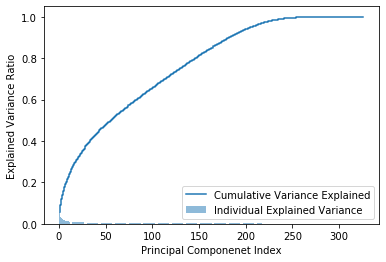

In [42]:
plt.bar(range(1,327), var_exp, alpha = .5, align = 'center', label = 'Individual Explained Variance')

plt.step(range(1,327), cum_var_exp, where = 'mid', label = 'Cumulative Variance Explained')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Componenet Index')
plt.legend(loc='best')
plt.show()

**Significant Findings**

To capture at least 80% of the variability in the dataset, we must include around 125 principal components. While this is a large number of features, our previous dataset contained 302 features. Our efforts to reduce the cardinality of several features were effective. 

We will pair the eigenvectors with their corresponding eigenvalues and project them onto a 2-dimensional subspace and observe the results.

In [43]:
# making a listof (eigenvalues, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

#sort the (eigenvalue, eigenvector) tuples from high to low
"""eigen_pairs[0] is equivalent to the single eigenvalue for PC1 and the eigenvector that represents the 190 features of the data"""
eigen_pairs.sort(key=lambda k: k[0], reverse = True)

#collecting the two eigenvectors that correspond to the two largest eigenvalues

W = np.hstack((eigen_pairs[0][1][:,np.newaxis],
               eigen_pairs[1][1][:,np.newaxis]))

# printing the first 5 pairs
print('Matrix W: \n', W[:5])

Matrix W: 
 [[-0.03112655 -0.00332737]
 [ 0.01428164  0.02652703]
 [-0.00576126  0.00453904]
 [ 0.0153833   0.02209266]
 [ 0.00340376  0.00048951]]


We can use this matrix to transform the training set into new features and plot them. First, we will observe the first 2 Principal Components with a logistic regression-based decision boundary to view the discriminatory ability of a logistic model using the Principal Components.

In [44]:
#transforming data
X_pca = X_std.dot(W)

# identifying labels
y_pca = data.TARGET

#initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components =2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')
# dimensionality reduction:
X_pca = pca.fit_transform(X_std)
#fitting the logitistic regression model on the reduced dataset:
lr.fit(X_pca, y_pca)
plot_decision_regions(X_pca, y_pca, classifier = lr)
plt.title('Logistic Regression: Decision Boundary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [33778, 307511]

**Significant Findings**

From this plot, we can see that class separation is very poor and non-linear. We have two centroids where each has only a slight concentric-ellipse type of separation between the two classes. The decision boundary drawn by a logistic model is clearly unable to use the first two principal components to discriminate between defaults and non-defaulted loans.


We can also attempt to view the value of the third principal component to see if there is good separation when we add a third dimension.

In [27]:
# getting three principal components
W3 = np.hstack((W,eigen_pairs[2][1][:,np.newaxis]))
W3.shape

(326, 3)

In [28]:
#transforming training data
X_pca3 = X_std.dot(W3)
X_pca3.shape

(307511, 3)

In [31]:
X_pca3[:10,:]

array([[-3.6600926 +0.j, -0.10526478+0.j, -0.13417634+0.j],
       [-0.22692169+0.j, -3.91638704+0.j,  0.09676031+0.j],
       [-6.02746049+0.j,  0.44800945+0.j, -0.64520426+0.j],
       [ 4.28433742+0.j, -0.58719161+0.j,  1.06701953+0.j],
       [ 0.48885546+0.j, -2.62098338+0.j,  1.13188733+0.j],
       [-1.17604636+0.j, -1.97421468+0.j,  0.20506668+0.j],
       [-4.56618178+0.j, -0.43215067+0.j, -1.33208055+0.j],
       [-4.7109809 +0.j, -1.65896707+0.j, -1.16507453+0.j],
       [ 4.51620746+0.j, -0.46317666+0.j, -1.05006942+0.j],
       [ 1.80855049+0.j, -1.32837513+0.j,  2.62315961+0.j]])

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')


colors = ['r','g']
markers = ['o', 'x']

# for each index and class in:
for idx, cl in enumerate(np.unique(y_pca)):
    ax.scatter3D(X_pca3[y_pca == cl, 0],
                X_pca3[y_pca == cl, 1],
                X_pca3[y_pca == cl, 2],
                label = cl,
                s=500,
                c = X_pca3[y_pca == cl, 2],
                cmap = 'viridis',
                marker = markers[idx])

**Significant Findings**

A three dimensional plot of the data does provide some insights. Defaults can be separated along the third dimension, as indicated by the defaults being clustered in the blue region and the non-defaults being clustered in the green/yellow regions of the third Principal Component.

1. The overlap between the classes is so signficant even in the third dimension, that the boundary line is not clear.

2. We will apply sampling strategies that will clarify the class boundaries.

## 1.1.2 Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). (Q1b) <a class="anchor" id="FinalDataset"></a>

### VIF Feature Removal / Dimensionality Reduction <a class="anchor" id="VIF"></a>

High VIF is an [indication of multicollinearity](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html).
Typically, limiting VIF of individual features to 5 is considered reasonable.
For removal by VIF, features with high VIF were removed iteratively until the VIF for all remain features was less than 5.
The removed features are printed by the code below.

In [34]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0):
        """Iteratively calculate VIF and drop features with highest VIF until
        all VIF values are below the threshold value (`thresh`).
        
        Adapted from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
        """
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

### 1.2.1 Feature Selection <a class="anchor" id="FeatureSelection"></a>

Feature selection was performed by removing features with high variance inflation factor (VIF) and ranking features by feature importance  with an ensemble of models (regularized logistic regression).


In [35]:
transformer = ReduceVIF()
X = transformer.fit_transform(X_train_svm_as_df)

ReduceVIF fit
ReduceVIF transform
Dropping FLAG_EMP_PHONE with vif=inf
Dropping OBS_60_CNT_SOCIAL_CIRCLE with vif=305.3561309024784
Dropping DAYS_EMPLOYED with vif=26.563116707417766
Dropping CREDIT_INCOME_RATIO with vif=12.802783700440655
Dropping FLAG_DOCUMENT_3 with vif=12.359954352518328
Dropping REGION_RATING_CLIENT with vif=11.328873613921926
Dropping REG_REGION_NOT_WORK_REGION with vif=8.86833737152621
Dropping REG_CITY_NOT_WORK_CITY with vif=6.576086450010426


**Splitting the Data**

Now that we have the `CAT_INCOME` feature, we can gather the features we want to include in our model and form strata. 

Before we perform any sampling techniques, we must split our data into training and test sets. Our training set will consist of approximately 80% of the data, while the test set will be set aside for validation.
Imputation is only calculated based on the training data.

In [19]:
# read in the data without imputions that are distribution dependent
data = read_clean_data(preimpute = False)

Before we create our income strata, we will stratefy the training and test data by the `TARGET` variable to assure that class labels in both the training and test sets a distributed the same way.

**Imputation**

The function `impute_data` calculates imputations values for the following values and applies these values to test set.
For categorical variables imputation of the mode was used.
For continuous variables imputation of the median was used.

| Variable | Imputation Method |
|----------|-------------------|
| CODE_GENDER | Mode |
| NAME_TYPE_SUITE | Mode |
| OBS_30_CNT_SOCIAL_CIRCLE | Median |
| DEF_30_CNT_SOCIAL_CIRCLE | Median |
| OBS_60_CNT_SOCIAL_CIRCLE | Median |
| DEF_60_CNT_SOCIAL_CIRCLE | Median |
| AMT_ANNUITY |  Median |
| ANNUITY_INCOME_RATIO |  Median |
| DAYS_LAST_PHONE_CHANGE |  Median |


In [23]:
# combine the imputated test and train for analysis of the SVM
data_imputed = pd.concat([X_train, X_test])

In [25]:
# preparing training data 

#removing TARGET from training data
y_train = X_rus.pop('TARGET')
#getting dummy variables
X_train = pd.get_dummies(X_rus, drop_first = True)


# preparing test data for evaluation
y_test = X_test.pop('TARGET')
# create SVM test set with out dummies
X_test_svm = X_test.copy()
# create test set with dummies
X_test = pd.get_dummies(X_test, drop_first = True)

# define a function to make empty features for missing features
cols = list(X_train.columns)
def add_missing_dummies(d, cols):
    missing_cols = set(cols) - set(d.columns)
    for c in missing_cols:
        d[c] = 0
add_missing_dummies(X_test, cols)

print('Shape of Training set: ' + str(X_train.shape) + '\nShape of Test set: ' + str(X_test.shape))

Shape of Training set: (207915, 176)
Shape of Test set: (61503, 176)


**Resampling the Training Data**

Initially, the models were trained against training data that contained mostly non-defaulting instances. However, the model's performance on this initial training data was inferior, generally failing to classify any defaulting instances. The remedy to this issue was to resample the training data to balance the number of non-defaulting and defaulting instances. All the defaulting instances were retained, but the non-defaulting instances were randomly downsampled to match the number of non-defaulting instances. Resampled training data improved the performance of the models substantially when validated on the test data. 

The test data was **not** resampled.

Additionally, the categroical variables were label encoded, rather than one-hot encoded.

In [27]:
#removing TARGET from training data
y_train_SVM = y_train.copy()
#getting dummy variables
X_train_SVM = X_rus.copy()

In [28]:
# need to down sample to deal with training computation time
# training on whole set takes about 12hr
# use about 20% of the training data
downsampled = X_train_SVM.copy()
downsampled['TARGET'] = y_train_SVM

In [29]:
cols_encode = ['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START','OCCUPATION_TYPE',
              'NAME_FAMILY_STATUS','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE',
              'NAME_HOUSING_TYPE','NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']

le = LabelEncoder()
for col in cols_encode:
    downsampled[col] = le.fit_transform(downsampled[col])
    X_test_svm[col] = le.transform(X_test_svm[col])

downsampled = downsampled.drop(labels = ['EXT_SOURCE_3','EXT_SOURCE_1','AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                                         'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE'], axis = 1)
X_test_svm = X_test_svm.drop(labels = ['EXT_SOURCE_3','EXT_SOURCE_1','AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                                         'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE'], axis = 1)


In [30]:
defaults = downsampled.query('TARGET == 1')
nominal = downsampled.query('TARGET == 0').sample(n = np.round(0.5 * (defaults.TARGET.size / 0.5)).astype(int),
                                                  random_state = random_state)
# join dataframes and shuffle
downsampled = pd.concat([defaults, nominal]).sample(frac = 1, 
                                                    random_state = random_state)

X_train_svm = downsampled.drop(labels = ['TARGET'], axis = 1)
y_train_svm = downsampled.TARGET

# transform the data
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

In [31]:
X_train_svm_as_df = pd.DataFrame(X_train_svm, columns=downsampled.drop(labels = ['TARGET'], axis = 1).columns)

## 1.2 Describe the final dataset that is used for classification/regression (Q1B)<a class="anchor" id="FinalDataset"></a>


### Logistic Regression <a class="anchor" id="LogsticRegression"></a>

Each type of regularized logistic regression (L1, L2, ElasticNet) was grid search for the bast hyperparameters.
Then the regularized logistic regression models were fit with the hyperparameters selected by [grid search]().
After the fits, features where ranked by the mean absolute importance from the model fits ([see table](#FI)).

**Note**: ElasticNet was not refit because the grid search or elastic net selected 0 for the regularization mixing parameter,
  which is just L1 regularization.

In [36]:
logistic_l1 = LogisticRegression(C = 0.046,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 random_state = random_state)
logistic_l1.fit(X, y_train_svm);

In [37]:
coefs = logistic_l1.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l1 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l1['Abs Weight'] = np.abs(final_df_logistic_l1['Logistic Weight'])
final_df_logistic_l1.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l1.to_string(index=False))

In [38]:
logistic_l2 = LogisticRegression(C = 0.001, 
                                 penalty = 'l2',
                                 solver = 'lbfgs', 
                                 random_state = random_state)
logistic_l2.fit(X, y_train_svm);

In [39]:
coefs = logistic_l2.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l2 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l2['Abs Weight'] = np.abs(final_df_logistic_l2['Logistic Weight'])
final_df_logistic_l2.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l2.to_string(index=False))

In [40]:
# prevent risk of object corruption
l2 = final_df_logistic_l2.sort_values('Feature').copy().add_suffix('_l2')
l1 = final_df_logistic_l1.sort_values('Feature').copy().add_suffix('_l1')

### Feature Importance <a class="anchor" id="FI"></a>

The importances were combined for each model and ranked by the mean absolute importance (logstic weight).
The weights for each model were also included. 
The difference and percent difference between the weights for each model is also shown.

The difference in feature weight between the two models is not substantial in the first 30 features.
There are only a feature features with substantial differences in weights, such as sign changes.
All of these features have low importances.

In [41]:
combined = pd.concat([l1, l2], keys=['Feature_l1', 'Feature_l2'], axis = 1)
combined['Average Weight'] = (combined['Feature_l1']['Abs Weight_l1'] 
                              + combined['Feature_l2']['Abs Weight_l2']) / 2
average_weights = pd.DataFrame()
average_weights['Mean_Abs_Weight'] = combined['Average Weight']
average_weights['Feature'] = combined['Feature_l1']['Feature_l1']
average_weights['l1_Weight'] = combined['Feature_l1']['Logistic Weight_l1']
average_weights['l2_Weight'] = combined['Feature_l2']['Logistic Weight_l2']
average_weights['Importance_Difference'] = average_weights['l1_Weight'] - average_weights['l2_Weight']
average_weights['Importance_Difference_%'] = (average_weights['Importance_Difference'] 
                                              / average_weights['Mean_Abs_Weight'] 
                                              * 100)
average_weights = average_weights.sort_values('Mean_Abs_Weight', ascending = False).reset_index(drop = True)
average_weights

,Mean_Abs_Weight,Feature,l1_Weight,l2_Weight,Importance_Difference,Importance_Difference_%
0,0.438435,EXT_SOURCE_2,-0.466907,-0.409962,-0.056945,-12.988139
1,0.166287,PERCENT_EMPLOYED_TO_AGE,-0.178329,-0.154244,-0.024085,-14.483756
2,0.162195,CODE_GENDER,-0.172420,-0.151970,-0.020450,-12.608409
3,0.141661,DAYS_BIRTH,-0.147777,-0.135544,-0.012233,-8.635488
4,0.135792,NAME_EDUCATION_TYPE,0.141790,0.129794,0.011996,8.834419
5,0.130236,NAME_CONTRACT_TYPE,-0.137310,-0.123161,-0.014149,-10.864146
6,0.114005,FLAG_OWN_CAR,-0.126493,-0.101516,-0.024977,-21.908926
7,0.098678,DAYS_ID_PUBLISH,-0.101697,-0.095660,-0.006037,-6.117967
8,0.094373,EMPLOYED,0.103532,0.085214,0.018318,19.410444
9,0.087284,REGION_RATING_CLIENT_W_CITY,0.088142,0.086426,0.001715,1.965330


### Refit with Important Features <a class="anchor" id="Refit"></a>

The L2 regularized logistic model was refit with the 15 most important features (shown below).
The produces 64.99% recall and 15.12% precision, which is an improvement over the baseline logistic model (Recall: 63.06%, Precision: 14.36%).

In [42]:
average_weights.iloc[0:15].Feature

0                    EXT_SOURCE_2
1         PERCENT_EMPLOYED_TO_AGE
2                     CODE_GENDER
3                      DAYS_BIRTH
4             NAME_EDUCATION_TYPE
5              NAME_CONTRACT_TYPE
6                    FLAG_OWN_CAR
7                 DAYS_ID_PUBLISH
8                        EMPLOYED
9     REGION_RATING_CLIENT_W_CITY
10       DEF_30_CNT_SOCIAL_CIRCLE
11                FLAG_WORK_PHONE
12         DAYS_LAST_PHONE_CHANGE
13         REG_CITY_NOT_LIVE_CITY
14               NAME_INCOME_TYPE
Name: Feature, dtype: object

In [43]:
l = LogisticRegression(C = 0.001, 
                         penalty = 'l2',
                         solver = 'lbfgs', 
                         random_state = random_state)
l.fit(X[average_weights.iloc[0:15].Feature],y_train_svm)
X_test_asdf = pd.DataFrame(X_test_svm, columns=downsampled.drop(labels = ['TARGET'], axis = 1).columns)
preds = l.predict(X_test_asdf[average_weights.iloc[0:15].Feature])
classification_report(y_test, preds)

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          37781  18757  56538
1           1857   3108   4965
All        39638  21865  61503

Accuracy: 66.48% 
Precision: 14.21% 
Recall: 62.60%


**ROC Curve**

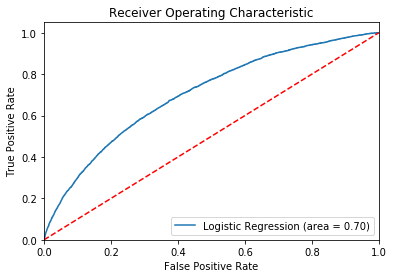

In [44]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, l.predict_proba(X_test_asdf[average_weights.iloc[0:15].Feature])[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression Parameter Grid Search <a class="anchor" id="GridSearch"></a>

Each type of regularized logistic regression was grid search for the best hyperparameters before fitting the model for estimating feature importances.

* L2 Regulaization
* L1 Regulaization
* Elastic Net Regulaization

### L2 Regulaization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ for L2 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [45]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'newton-cg',
                     'lbfgs',
                     'sag',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l2', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
# Fit on data
#best_clf = clf.fit(X_train_svm, y_train_svm)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.3593813663804626, 'solver': 'saga'}

Grid scores on development set:

0.644 (+/-0.005) for {'C': 0.0001, 'solver': 'newton-cg'}
0.644 (+/-0.005) for {'C': 0.0001, 'solver': 'lbfgs'}
0.644 (+/-0.005) for {'C': 0.0001, 'solver': 'sag'}
0.644 (+/-0.005) for {'C': 0.0001, 'solver': 'saga'}
0.647 (+/-0.007) for {'C': 0.000774263682681127, 'solver': 'newton-cg'}
0.647 (+/-0.007) for {'C': 0.000774263682681127, 'solver': 'lbfgs'}
0.647 (+/-0.007) for {'C': 0.000774263682681127, 'solver': 'sag'}
0.647 (+/-0.007) for {'C': 0.000774263682681127, 'solver': 'saga'}
0.648 (+/-0.007) for {'C': 0.005994842503189409, 'solver': 'newton-cg'}
0.648 (+/-0.007) for {'C': 0.005994842503189409, 'solver': 'lbfgs'}
0.648 (+/-0.007) for {'C': 0.005994842503189409, 'solver': 'sag'}
0.648 (+/-0.007) for {'C': 0.005994842503189409, 'solver': 'saga'}
0.648 (+/-0.007) for {'C': 0.046415888336127774, 'solver': 'newton-cg'}

## l1 Regularization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘liblinear’ and ‘saga’ for L1 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [ ]:
```python
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'liblinear',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l1', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
```

### Elastic Net
#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-4, 4) with 10 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘saga’ for elastic-net
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 10 steps

In [ ]:
```python
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':['saga'],
        'C':np.logspace(-4, 4, 10),
        'l1_ratio':np.linspace(0, 1, 10)
    }]

model = LogisticRegression(penalty = 'elasticnet', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
```

## 2.  Stage Four - Modeling and Evaluation (Q2) <a class="DataUnderstanding" id="EDA"></a>

## 2.1 Choose and explain your evaluation metrics (Q2A) <a class="anchor" id="Evaluaation"></a>


Due to the significant overlap between the classes in our dataset, we have elected to evaluate our models using the recall metric. Recall is the ratio of accurately predicted defaults to total defaults, which allows us to extract value from the model. 

We will provide an example of why we deemed this necessary.

Below is a Gradient Boosting Machines model that uses the entire dataset to make class predictions:

In [ ]:
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
 # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier().fit(X_train_std, y_train)
clf.score(X_train_std, y_train)

An accuracy of 92% is deceptive. The significant imbalance of the dataset creates this deception. The goal of the analysis is to build a model capable of predicting loan defaults. If we remember that over 90% of the loans in the dataset were in good standing, we can then understand how our model can easily achieve an accuracy of at least 90% by sheer coincidence. 

We will now observe the recall of the trained model:

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train_std, y_train, cv = 5, scoring = 'recall')

The recall ability of this model ranges from 1.1% to 1.3%. This reveals that the model is useless for predicting loan defaults. 

We will experiment with various resampling strategies until significant improvements are made.

## 2.2 Choose the method you will use for dividing your data (Q2B) <a class="anchor" id="Describedata"></a>

We are using an 80/20 training : test set split.

As previously mentioned in section 1.2 (Data Description) we concluded that it was necessary to implement a sampling strategy on the training set in order to make a useful model for predicting loan defaults. 

As a justification of the use of a generic sampling strategy with this dataset, we will provide an example of the effectiveness of simple Randum Under Sampling.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X = X_train_std
y = data.TARGET
rus = RandomUnderSampler(random_state = 1)
X_rus, y_rus = rus.fit_resample(X,y)
y_rus.shape

In [ ]:
clf = HistGradientBoostingClassifier().fit(X_rus, y_rus)
clf.score(X_rus, y_rus)

In [ ]:
cross_val_score(clf, X_rus, y_rus, cv = 5, scoring = 'recall')

Applying random under-sampling of the majority class permits the gradient boosting algorithm to better define the class differences. Our ability to detect loans that enter default status increased over 60%.

## 2.3  Create three different classification/regression models (Q2C) <a class="anchor" id="Models"></a>



Fill

## 2.4 Analyze the results using your chosen method of evaluation (Q2D) <a class="anchor" id="Analyze"></a>


Fill

## 2.5 Discuss the advantages of each model for each classification task (Q2E) <a class="anchor" id="Advantages"></a>


Fill

## 2.6 Which attributes from your analysis are most important (Q2F) <a class="anchor" id="Attributes"></a>


Fill

# 3. Stage Five - Deployment (Q3) <a class="anchor" id="Deployment"></a>

## 3.1 How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? (Q3A) <a class="anchor" id="Value"></a>



# A1. Disclaimer<a class="anchor" id="Disclaimer"></a>

## Disclaimer for Home Credit Default Research Paper
If you require any more information or have any questions about this papers disclaimer, please feel free to contact us by email at mschwan@smu.edu
## Disclaimers for Home Credit Default Research Paper
All the information for this research paper is published in good faith and for general information purpose only. Spring 2020 SMU Machine Learning One project team Schwan, Adams, Stewart, and Howard does not make any warranties about the completeness, reliability, and accuracy of this information. Any action you take upon the information you find within this paper is strictly at your own risk. This project team will not be liable for any losses and/or damages in connection with the use of our research analysis paper.
From our references, you can visit other websites and papers by following hyperlinks to such external sites. While we strive to provide only quality research references to useful and ethical content, we have no control over the content and nature of these sites. These links to other websites and papers do not imply a recommendation for all the content found within. Please be also aware that when you leave our website, other sites may have different privacy policies and terms which are beyond our control. Please be sure to check the Privacy Policies of these sites as well as their “Terms of Service” before engaging in any business or uploading any information.
## Consent
By reading our research paper content, you hereby consent to our disclaimer and agree to its terms.
## Update
Should we update, amend or make any changes to this document, those changes will be prominently posted here.

